This code has all algorithm which we proposed and we check it using two types of laplacian that is symmetic and unnormalized laplacian. 
And we have set the precision for the edge weigths here so we get desired results for the Petersen graph.
Here we have used edge weigths as (f_i - f_j)^2. 

And we are doing it for just for graphs with edge weigth 1 or 0.

# here i have added the code for random walk laplacian 


In [1]:
import numpy as np
import scipy as sp
from numpy import linalg as LA
import networkx.linalg.algebraicconnectivity as alg
import collections 
import math
import pandas as pd


Results_ncut = pd.DataFrame(index = ['SLUP','SLP', 'SLS', 'UnUP','UnP', 'UnS','RwUP','RwP', 'RwS'])
Results_conductance = pd.DataFrame(index = ['SLUP','SLP', 'SLS', 'UnUP','UnP', 'UnS','RwUP','RwP', 'RwS'])
Graphs = []

In [2]:
# This wil get us the similarity matrix W given the graph and the number of vertices n.
# the vertices are number form 0 to n - 1.
def get_matrix2(graph, n):
    
    w = np.zeros((n, n))
   
    for x in graph.keys() :
        for y in graph[x]:
            w[x][y] = 1
            w[y][x] = 1

    return w
    

In [3]:
def get_unnormalized_laplacian(w):
    
    D = w.sum(axis = 1)
    
    D = np.diag(D)  # The degree matrix D
    
    L = D - w
    
    return L

In [4]:
def get_symmetric_laplacian(w):
    
    D = w.sum(axis = 1)
    D_sqrt = np.sqrt(D)
    
    D_1 = np.reciprocal(D_sqrt)
    D_1 = np.diag(D_1)  
    D = np.diag(D)
    L = np.dot(D_1, np.dot(D - w, D_1))
    
    return L

In [5]:
def get_random_walk_laplacian(w):
    
    D = w.sum(axis = 1)
    
    D_1 = np.reciprocal(D)
    D_1 = np.diag(D_1)  
    D = np.diag(D)
    L = np.dot(D_1, np.dot(D - w, D_1))
    
    return L

In [6]:
# returns the fielder eigen vector given the similartiy matrix W.

def get_fielder(l, n):  #Similairty matix W

    eigvals, eigvecs = sp.linalg.eigh(l)# eigen values and eigen vectors of the unnormalized laplacian D - W 
    #print("Eigenvalues: ",eigvals, "\n")
    eigvecs = np.round( eigvecs, 5)
    eigvals = np.round(eigvals, 4)
    cardinality = 1
    
    fielder_eigval = eigvals[1]
    
    #print(fielder_eigval)
    while(cardinality < n and abs(eigvals[cardinality] - fielder_eigval)<0.000001):
        cardinality = cardinality + 1
        
    fielder = eigvecs.T[1:cardinality, :] #The 2nd smallest eigen vector of the laplacian L = D - W
    
    return fielder



In [7]:
# Checks weather the graph has to connected components or not i.e is the garph paritioned into two clusters 

def check_partion(w, n): # Similarity matrix W and the number of vetrices n
    
    # We will do bfs and check if the graph is partitioned into two parts or not 
    explored = [0]*n 
    
    queue = collections.deque([0])
    
    queue_size = 1
    
    while(queue_size != 0):
        
        node = queue.popleft()
        queue_size -= 1
        
        if explored[node] == 0:
            
            explored[node] = 1
 
            for i in range(0, n):
                if(w[node][i] != 0):
                    neighbour = i
                    
                    if(explored[neighbour] == 0):
                        queue.append(neighbour)
                        queue_size += 1
    
    # Just need to check if this graph has been partitioned into two parts or not 
    is_partitioned = False
    
    for node in explored:
        if node == 0:
            is_partitioned = True
    
    return is_partitioned  

    


In [8]:
# If the graph has been paritioned into two parts we need to know what these partitions are this function gives us that
# not only does it outputs the clusters but also a vector whose ith index is 1 if its in the first cluster otherwise 0.

def get_partition(w, n): # the similrity matrix W and the number of vertices n
    
    # We will do bfs from a vertex and find out its conected component the other vertices which are not in the
    # connected component are in the other cluster 
    clusters = [[], []]
    explored = [0]*n
    
    
    queue = collections.deque([0])
    
    queue_size = 1
    
    
    while(queue_size != 0):
        
        node = queue.popleft()
        queue_size -= 1
        
        if explored[node] == 0:
            
            explored[node] = 1
 
            for i in range(0, n):
                if(w[node][i] != 0):
                    neighbour = i
                    
                    if(explored[neighbour] == 0):
                        queue.append(neighbour)
                        queue_size += 1
    
    
    #If it a node is connected to vertex zero then its in cluster 0 otherwise its in cluster 1. 
    for node in range(0, n):
        if explored[node] == 1:
            clusters[0].append(node)
        else:
            clusters[1].append(node)
    
    return clusters, explored



In [9]:
def get_edge_weights(f, w, n):
    
    new_weight = []
    D = w.sum(axis = 1)
    D_sqrt = np.sqrt(D)
    
    for i in range(0, n):
        for j in range(0, n):
            if(w[i][j] != 0):
                new_weight.append([np.dot((f[:,i] - f[:,j]).T,f[:,i] - f[:,j]), i, j])
    
    new_weight = [ [round(i, 3) for i in elem] for elem in new_weight]
    new_weight = sorted(new_weight, reverse= True)
    

    return new_weight

In [10]:
# Here we use our current algorithm to partition the graph
# This returns the clusters, the cluster_name vector and the edeges cut
def get_clusters(f, w, n): # the similarity matrix and the number of vertices
    
    new_weight = get_edge_weights(f, w, n)
    
    new_weight.sort(reverse= True)

    new_weight = collections.deque(new_weight)

    new_w = w.copy() # Here we copy the similarity matrix so that when we make changes to new_w nothing happens to the origianl similarty matrix

    edges_cut = []
    while(check_partion(new_w, n) == False):  # keep on removing edges until we have a parition
        edge_remove = new_weight.popleft()

        u = edge_remove[1]
        v = edge_remove[2]

        if(new_w[u][v] != 0):
            edges_cut.append([u,v])

        new_w[u][v] = 0
        new_w[v][u] = 0
        
    
    clusters, cluster_name = get_partition(new_w, n) 
    
    # this part changes the cluster_name from a list to numpy array (This step helps to write easy codes)
    cluster_name = np.asarray(cluster_name)
    cluster_name = np.reshape(cluster_name, (1,n))
    
    
    return clusters, cluster_name, edges_cut 


In [11]:
def ncut(cluster_name, w, n):
    
    cluster_name = np.asarray(cluster_name)
    cluster_name = np.reshape(cluster_name, (1,n))
    
    mull_1 = cluster_name
    mull_2 = np.ones((1,n)) - mull_1
    
    w_1 = np.dot(mull_1, np.dot(w, np.ones((n,1))))
    w_2 = np.dot(mull_2, np.dot(w, np.ones((n,1))))
    
    
    cut = np.dot(mull_1, np.dot(w,mull_2.T))
    #print(cut, w_1,w_2)
    
    ans = cut*(1/w_1 + 1/w_2)
    ans_1 = cut/min(w_1, w_2)
    
    return ans[0][0], ans_1[0][0] 

    

In [12]:
def get_cut(clusters, w, n):
    cut = []
    for x in clusters[0]:
        for y in clusters[1]:
            if(w[x][y] != 0):
                cut.append([x,y])
    return cut

In [13]:
def get_results(l, n, w):
    
    
    fielder = get_fielder(l, n)
    add_col_ncut = []
    add_col_con = []
    
    clusters, cluster_predict , edges_cut = get_clusters(fielder, w, n) 
    nc, c = ncut(cluster_predict, w, n)
   
    add_col_ncut.append(nc)
    add_col_con.append(c)
    
    clusters, cluster_predict , edges_cut = get_clusters(np.reshape(fielder[0,:],(1,n)), w, n) 
    nc, c = ncut(cluster_predict, w, n)
   
    add_col_ncut.append(nc)
    add_col_con.append(c)
    
    cluster_predict = [0]*n
    
    clusters = [[], []]
    for i in range(0, n):
        if(fielder[0][i] <= 0):
            cluster_predict[i] = 0
            clusters[0].append(i)
        else:
            cluster_predict[i] = 1
            clusters[1].append(i)
    
    nc, c = ncut(cluster_predict, w, n)
    add_col_ncut.append(nc)
    add_col_con.append(c)
    
    
    return add_col_ncut, add_col_con

In [14]:
def get_results_1(l, n, w):
    
    
    fielder = get_fielder(l, n)
    add_col_ncut = []
    add_col_con = []
    
    clusters, cluster_predict , edges_cut = get_clusters(fielder, w, n) 
    nc, c = ncut(cluster_predict, w, n)
   
    add_col_ncut.append(nc)
    add_col_con.append(c)
    
    clusters, cluster_predict , edges_cut = get_clusters(np.reshape(fielder[0,:],(1,n)), w, n) 
    nc, c = ncut(cluster_predict, w, n)
   
    add_col_ncut.append(nc)
    add_col_con.append(c)
    
    cluster_predict = [0]*n
    
    clusters = [[], []]
    for i in range(0, n):
        if(fielder[0][i] <= 0):
            cluster_predict[i] = 0
            clusters[0].append(i)
        else:
            cluster_predict[i] = 1
            clusters[1].append(i)
    
    nc, c = ncut(cluster_predict, w, n)
    add_col_ncut.append(nc)
    add_col_con.append(c)
    
    
    return add_col_ncut, add_col_con

In [15]:
def unnormalized_results(graph, print_results):

    n = graph[1][0]
    graph = graph[0][0]
    w = get_matrix2(graph, n)

    l = get_unnormalized_laplacian(w)
    
    if(print_results == True):
        print("\nunnormalized results\n")
        return get_results(l, n, w)
    else:
        return get_results_1(l, n, w)

In [16]:
def symmetric_results(graph, print_results):

    n = graph[1][0]
    graph = graph[0][0]
    w = get_matrix2(graph, n)

    l = get_symmetric_laplacian(w)
    
    if(print_results == True):
        print("\nsymmetric results\n")
        return get_results(l, n, w)
    else:
        return get_results_1(l, n, w)

In [17]:
def random_walk_results(graph, print_results):

    n = graph[1][0]
    graph = graph[0][0]
    w = get_matrix2(graph, n)

    l = get_random_walk_laplacian(w)
    
    if(print_results == True):
        print("\nRandomwalk results\n")
        return get_results(l, n, w)
    else:
        return get_results_1(l, n, w)

In [18]:
def show_results(graph, print_results):
    
    add_col_ncut, add_col_con  = [], []
    
    add_col_ncut, add_col_con = symmetric_results(graph[1], print_results)
    un, uc = unnormalized_results(graph[1], print_results)
    rwn, rwc = random_walk_results(graph[1], print_results)
    
    add_col_ncut += un
    add_col_con += uc
    
    add_col_ncut += rwn
    add_col_con += rwc
    
    Results_ncut[graph[0]], Results_conductance[graph[0]] = add_col_ncut, add_col_con
    return 0

In [19]:
Petersen = ['Petersen', [[{0 : [2, 3],
         1 : [4, 3],
         2 : [0, 4],
         3 : [0, 1],
         4 : [1, 2],
         5 : [6, 0],
         6 : [7, 1],
         7 : [8, 2],
         8 : [9, 3],
         9 : [5, 4]
             }],
        [10]]]

Graphs.append(Petersen)
show_results(Petersen, True)


symmetric results


unnormalized results


Randomwalk results



0

In [20]:
Enneahedron = ['Enneahedron', [[{0 : [1, 3, 4],
         1 : [0, 2, 4, 5],
         2 : [1, 3, 6],
         3 : [0, 7, 6, 2],
         4 : [0, 1, 5, 6, 7],
         5 : [1, 4, 6],
         6 : [2, 3, 4, 5, 7],
         7 : [4, 3, 6],
             }],
        [8]]]
Graphs.append(Enneahedron)
show_results(Enneahedron, True)


symmetric results


unnormalized results


Randomwalk results



0

In [21]:
Enneahedron_1 = ['Enneahedron_1',[[{0 : [1, 3, 4],
         1 : [0, 2, 4, 6, 5],
         2 : [1, 3, 5],
         3 : [0, 4, 7, 5, 2],
         4 : [0, 1, 3, 6],
         5 : [1, 7, 3, 2],
         6 : [1, 3, 4, 7],
         7 : [6, 5],
             }],
        [8]]]
Graphs.append(Enneahedron_1)
show_results(Enneahedron_1, True)


symmetric results


unnormalized results


Randomwalk results



0

In [22]:
Cockroach = ['Cockroach',[[{0 : [1],
         1 : [0, 2],
         2 : [1, 3],
         3 : [2, 4, 8],
         4 : [3, 5, 7],
         5 : [4, 6],
         6 : [5, 7],
         7 : [6, 8, 4],
         8 : [7, 9, 3],
         9 : [8, 10],
         10 : [11]
             }],
        [12]]]
Graphs.append(Cockroach)
show_results(Cockroach, True)


symmetric results


unnormalized results


Randomwalk results



0

In [23]:
Cockroach_1 = ['Cockroach_1', [[{0 : [1, 11],
         1 : [0, 2],
         2 : [1, 3],
         3 : [2, 4, 8],
         4 : [3, 5, 7],
         5 : [4, 6],
         6 : [5, 7],
         7 : [6, 8, 4],
         8 : [7, 9, 3],
         9 : [8, 10],
         10 : [11],
         11 : [0]    }],
        [12]]]

Graphs.append(Cockroach_1)
show_results(Cockroach_1, True)


symmetric results


unnormalized results


Randomwalk results



0

In [24]:
Path_point  = ['Path_point',[[{0 : [1],
         1 : [0, 2],
         2 : [1, 3],
         3 : [2, 4],
         4 : [3, 5],
         5 : [4, 6],
         6 : [5, 7],
         7 : [6, 8],
         8: [7, 9],
         9: [8, 10],
         10:[9, 11],
         11 :[0,1,2,3,4,5,6,7,8,9,10]
                }],
        [12]]]

Graphs.append(Path_point)
show_results(Path_point, True)


symmetric results


unnormalized results


Randomwalk results



0

In [25]:
Two_clusters = ['Two_clusters', [[{0 : [1, 2, 3],
         1 : [0, 2, 3, 4],
         2 : [0, 1, 3],
         3 : [0, 1, 2],
         4 : [5, 6, 7],
         5 : [4, 6, 7],
         6 : [4, 5, 7],
         7 : [4, 5, 6]
        }],
        [8]]]

Graphs.append(Two_clusters)
show_results(Two_clusters, True)


symmetric results


unnormalized results


Randomwalk results



0

In [26]:
Discrete_moons = {}

for i in range(0, 19):
    Discrete_moons[i] = [i + 1]
    Discrete_moons[i + 20] = [i + 21]

print(Discrete_moons)

for i in range(0, 10):
    Discrete_moons[i].append(19 - i)
    Discrete_moons[i + 20].append(39 - i)

for i in range(0, 5):
    Discrete_moons[i + 10].append(24 - i)
#print(Discrete_moons)

D_M = ['Discrete_moons',[[Discrete_moons], [40]]]

Graphs.append(D_M)
show_results(D_M, True)

{0: [1], 20: [21], 1: [2], 21: [22], 2: [3], 22: [23], 3: [4], 23: [24], 4: [5], 24: [25], 5: [6], 25: [26], 6: [7], 26: [27], 7: [8], 27: [28], 8: [9], 28: [29], 9: [10], 29: [30], 10: [11], 30: [31], 11: [12], 31: [32], 12: [13], 32: [33], 13: [14], 33: [34], 14: [15], 34: [35], 15: [16], 35: [36], 16: [17], 36: [37], 17: [18], 37: [38], 18: [19], 38: [39]}

symmetric results


unnormalized results


Randomwalk results



0

In [27]:
Double_Tree = {}

for i in range(1,10):
    Double_Tree[i] = [math.floor((i - 1)/2)]
    Double_Tree[i + 10] = [10 + math.floor((i - 1)/2)]

Double_Tree[0] = [10]

D_T = ['Double_Tree',[[Double_Tree], [20]]]

Graphs.append(D_T)
show_results(D_T, True)


symmetric results


unnormalized results


Randomwalk results



0

In [28]:
print(D_M)

['Discrete_moons', [[{0: [1, 19], 20: [21, 39], 1: [2, 18], 21: [22, 38], 2: [3, 17], 22: [23, 37], 3: [4, 16], 23: [24, 36], 4: [5, 15], 24: [25, 35], 5: [6, 14], 25: [26, 34], 6: [7, 13], 26: [27, 33], 7: [8, 12], 27: [28, 32], 8: [9, 11], 28: [29, 31], 9: [10, 10], 29: [30, 30], 10: [11, 24], 30: [31], 11: [12, 23], 31: [32], 12: [13, 22], 32: [33], 13: [14, 21], 33: [34], 14: [15, 20], 34: [35], 15: [16], 35: [36], 16: [17], 36: [37], 17: [18], 37: [38], 18: [19], 38: [39]}], [40]]]


In [29]:
Double_Tree1 = {}

for i in range(1,10):
    Double_Tree1[i] = [math.floor((i - 1)/2)]
    Double_Tree1[i + 10] = [10 + math.floor((i - 1)/2)]

Double_Tree1[0] = [10]

for i in range(5,9):
     Double_Tree1[i].append(10+i)
for i in range(0,9):
    Double_Tree1[i].append((i+1)%10)
D_T1 = ['Double_Tree1',[[Double_Tree1], [20]]]

Graphs.append(D_T1)
print(D_T1)
show_results(D_T1, True)



['Double_Tree1', [[{1: [0, 2], 11: [10], 2: [0, 3], 12: [10], 3: [1, 4], 13: [11], 4: [1, 5], 14: [11], 5: [2, 15, 6], 15: [12], 6: [2, 16, 7], 16: [12], 7: [3, 17, 8], 17: [13], 8: [3, 18, 9], 18: [13], 9: [4], 19: [14], 0: [10, 1]}], [20]]]

symmetric results


unnormalized results


Randomwalk results



0

In [30]:
for graph in Graphs:
    show_results(graph, False)
    
    

In [31]:
Results_conductance.T


,SLUP,SLP,SLS,UnUP,UnP,UnS,RwUP,RwP,RwS
Petersen,1.000000,1.000000,0.500000,1.000000,0.666667,0.466667,1.000000,0.666667,0.500000
Enneahedron,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
Enneahedron_1,0.714286,0.714286,0.375000,0.600000,0.600000,0.375000,0.375000,0.375000,0.375000
Cockroach,0.200000,0.200000,0.230769,0.200000,0.200000,0.230769,1.000000,1.000000,0.230769
Cockroach_1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.200000,0.200000,0.166667
Path_point,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.500000,0.500000,0.428571
Two_clusters,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923,0.076923
Discrete_moons,0.500000,0.500000,0.081967,0.071429,0.071429,0.081967,0.500000,0.500000,0.081967
Double_Tree,0.052632,0.052632,0.052632,0.052632,0.052632,0.052632,1.000000,1.000000,0.052632
Double_Tree1,0.333333,0.333333,0.250000,0.333333,0.333333,0.333333,0.333333,0.333333,0.263158


In [32]:
Results_ncut.T

,SLUP,SLP,SLS,UnUP,UnP,UnS,RwUP,RwP,RwS
Petersen,1.111111,1.111111,0.833333,1.111111,0.833333,0.933333,1.111111,0.833333,0.833333
Enneahedron,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667
Enneahedron_1,0.914286,0.914286,0.750000,0.872727,0.872727,0.750000,0.750000,0.750000,0.750000
Cockroach,0.247619,0.247619,0.461538,0.247619,0.247619,0.461538,1.040000,1.040000,0.461538
Cockroach_1,0.291667,0.291667,0.291667,0.291667,0.291667,0.291667,0.311111,0.311111,0.291667
Path_point,0.642857,0.642857,0.642857,0.642857,0.642857,0.642857,0.700000,0.700000,0.642857
Two_clusters,0.153846,0.153846,0.153846,0.153846,0.153846,0.153846,0.153846,0.153846,0.153846
Discrete_moons,0.516949,0.516949,0.163934,0.092705,0.092705,0.163934,0.516949,0.516949,0.163934
Double_Tree,0.105263,0.105263,0.105263,0.105263,0.105263,0.105263,1.027027,1.027027,0.105263
Double_Tree1,0.369048,0.369048,0.336957,0.350282,0.350282,0.413333,0.389937,0.389937,0.379437


In [33]:
print(Results_conductance.loc['UnP', :])

Petersen          0.666667
Enneahedron       0.333333
Enneahedron_1     0.600000
Cockroach         0.200000
Cockroach_1       0.166667
Path_point        0.428571
Two_clusters      0.076923
Discrete_moons    0.071429
Double_Tree       0.052632
Double_Tree1      0.333333
Name: UnP, dtype: float64


In [34]:
optimal_cuts = []

for i in range(1, 2**10 - 1):
    cluster_predict = [1]*10
    
    for j in range(0,10):
        if(2**j & i != 0):
            cluster_predict[j] = 0
    
    #print(cluster_predict)
    graph = Petersen[1][0]
    graph = graph[0]
    n = Petersen[1][1]
    n  = n[0]
    #print(ncut(cluster_predict, get_matrix2(graph, n), n))
    if(ncut(cluster_predict, get_matrix2(graph, n), n) == ncut([1,1,1,1,1,0,0,0,0,0], get_matrix2(graph, n), n)):
        
        clusters = [[], []]
        for i in range(0, 10):
            clusters[cluster_predict[i]].append(i)
            
        optimal_cuts.append(clusters)

for x in optimal_cuts:
    print(x)
print(len(optimal_cuts))

[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9]]
[[0, 1, 3, 5, 6], [2, 4, 7, 8, 9]]
[[1, 2, 4, 6, 7], [0, 3, 5, 8, 9]]
[[0, 2, 5, 6, 7], [1, 3, 4, 8, 9]]
[[0, 2, 3, 7, 8], [1, 4, 5, 6, 9]]
[[1, 3, 6, 7, 8], [0, 2, 4, 5, 9]]
[[0, 2, 4, 5, 9], [1, 3, 6, 7, 8]]
[[1, 4, 5, 6, 9], [0, 2, 3, 7, 8]]
[[1, 3, 4, 8, 9], [0, 2, 5, 6, 7]]
[[0, 3, 5, 8, 9], [1, 2, 4, 6, 7]]
[[2, 4, 7, 8, 9], [0, 1, 3, 5, 6]]
[[5, 6, 7, 8, 9], [0, 1, 2, 3, 4]]
12


In [35]:
d = Enneahedron_1[1][0][0]
for i in d.keys():
    for j in d[i]:
        if(i < j):
            print(str(i) + ' ' + str(j))

0 1
0 3
0 4
1 2
1 4
1 6
1 5
2 3
2 5
3 4
3 7
3 5
4 6
5 7
6 7


In [36]:
v = [0.46236,  0.16479, -0.33309, -0.08359,  0.50135, -0.49733,  0.1138,  -0.35984]

for i in range(0,8):
    print(str(i) + ", " + str(v[i]))

0, 0.46236
1, 0.16479
2, -0.33309
3, -0.08359
4, 0.50135
5, -0.49733
6, 0.1138
7, -0.35984


In [37]:
rncut = Results_ncut.T

In [38]:
y_SLP = rncut['SLP'].values
y_UnP = rncut['UnP'].values
y_RwP = rncut['RwP'].values
y_SLS = rncut['SLS'].values
y_UnS = rncut['UnS'].values
y_RwS = rncut['RwS'].values

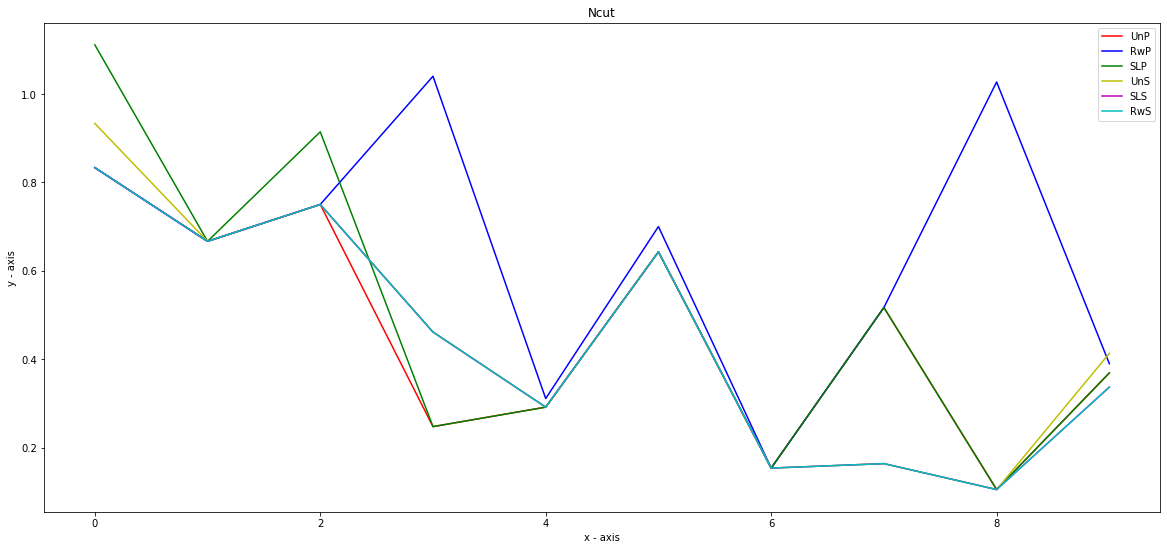

In [47]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

x = range(0,10) 
plt.plot(x, y_UnP, color ='r', label ='UnP') 
plt.plot(x, y_RwP, color ='b', label ='RwP') 
plt.plot(x, y_SLP, color ='g', label ='SLP') 
plt.plot(x, y_UnS, color ='y', label ='UnS') 
plt.plot(x, y_SLS, color ='m', label ='SLS') 
plt.plot(x, y_RwS, color ='c', label ='RwS') 

plt.xlabel('x - axis') 
plt.ylabel('y - axis') 
plt.title("Ncut")
plt.legend(loc='upper right')
plt.rcParams["figure.figsize"] = [20,9]
plt.show() 

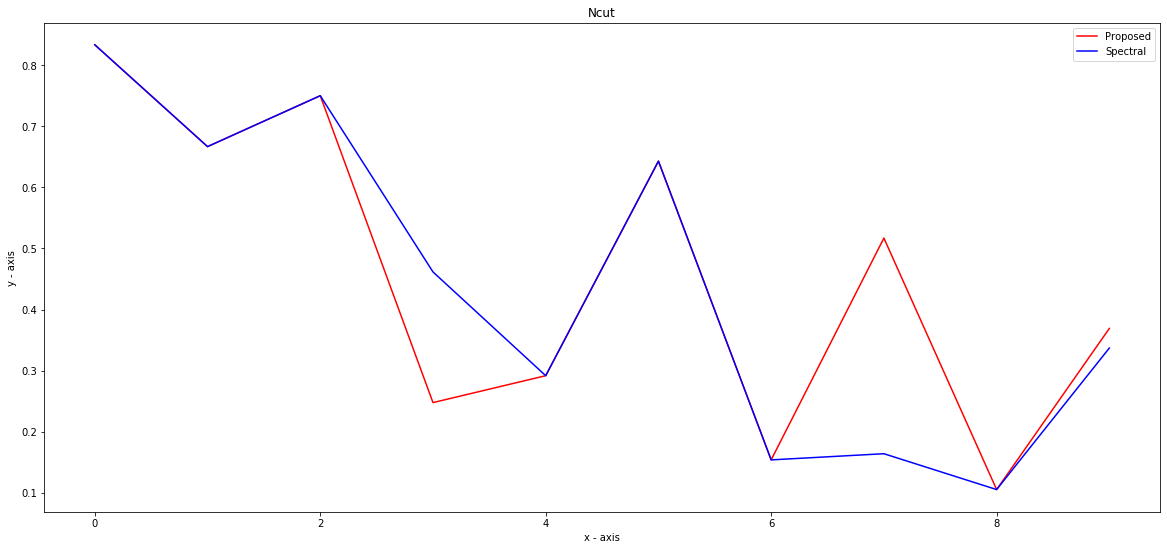

In [46]:
y_P = np.fmin(y_SLP, y_RwP, y_UnP)
y_S = np.fmin(y_SLS, y_UnS, y_RwS)

x = range(0,10) 
plt.plot(x, y_P, color ='r', label ='Proposed') 
plt.plot(x, y_S, color ='b', label ='Spectral') 

plt.xlabel('x - axis') 
plt.ylabel('y - axis') 
plt.title("Ncut")
plt.legend(loc='upper right')
plt.rcParams["figure.figsize"] = [20,9]
plt.show() 